Случайный вектор (xi_1, xi_2, xi_3, xi_4, xi_5, etta) имеет компоненты, распределенные по следующему закону: 
psi_k ~ R(-1, 1), etta ~ N(2 + 3*x_1 - 2*x_2 + x_3 + x_4 - x_5, 1.5**2)
Сгенерировать выборку объема n=50

In [352]:
from scipy.stats import norm, uniform, f, t, multivariate_normal, chi, chi2_contingency
from scipy.optimize import minimize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


In [353]:
p = 5 # количество случайных величин кси
n = 50  # объем выборки

# факторы - случайные величины равномерное распределенные на участке [a; b]
a, b = -1, 1
# отклик - это случайная величина распределенная нормально с параметрами mean, sd
mean = lambda X, coefs: np.dot(X, np.array(coefs)) + 2 # etta ~ N(2 + 3x_1 - 2x_2 + x_3 + x_4 - x_5, 1.5**2)
sd = 1.5

factors = [uniform(a, b-a) for _ in range(p)] #psi_k ~ R(-1, 1)
#вектор факторов
X = np.array([stat.rvs(size=n) for stat in factors]).T  # Т, чтобы каждая строка представляла один случайный вектор

# отклик
reaction = norm(mean(X, [3, -2, 1, 1, -1]), sd) # etta ~ N(2 + 3x_1 - 2x_2 + x_3 + x_4 - x_5, 1.5**2)
# реализация отклика
Y = reaction.rvs(size=n)
Y = Y.reshape(1, -1).T
sample = np.hstack((X, Y))

In [354]:
names = [f'$\\xi_{i}$' for i in range(1, p+1)] + [r'$\eta$']
df = pd.DataFrame(data=sample, columns=names)
print(df.shape)
df.head(10)

(50, 6)


,$\xi_1$,$\xi_2$,$\xi_3$,$\xi_4$,$\xi_5$,$\eta$
0,0.324426,0.247679,0.596298,0.627871,-0.788472,3.832853
1,-0.980013,0.183822,0.205116,0.649288,0.235783,-0.097368
2,-0.898224,-0.030263,-0.050250,0.453196,-0.541748,-0.267356
3,-0.999474,0.688524,-0.146266,0.284340,-0.767585,-1.839102
4,-0.640467,0.433535,0.377307,0.658133,-0.981116,-1.572713
5,0.324046,0.566481,0.063098,0.941092,-0.974607,3.671522
6,0.720729,0.190636,0.188236,-0.123329,0.853885,3.487902
7,0.826007,0.449336,0.507232,0.993547,0.613655,4.870319
8,0.101050,-0.617091,0.175155,0.517374,0.176772,4.331852
9,-0.981029,-0.207390,-0.194260,0.555495,0.392055,-1.049394


## a) Проверка переменных xi_k на мультиколлинеарность

In [355]:
R_squares = []
#Пример с семинара "значимость всей регрессии"
#берем проверяемый фактор за Y и проверяем значимость регрессии по остальным 4м факторам относительно него, (реальный Y игнорируется)
for i in range(p):
    PSI = np.hstack((X[:, :i], np.ones((n, 1)), X[:, i+1:])) #X кроме X_i
    Y_i = X[:, i].reshape(1, -1).T # X_i
    F = PSI.T @ PSI
    F_inv = np.linalg.inv(F) #F^-1
    beta_wave_i = F_inv @ PSI.T @ Y_i
    e = Y_i - PSI@beta_wave_i
    RSS = (e.T @ e)[0, 0]
    TSS = np.sum(((Y_i - Y_i.mean()).ravel()) ** 2) 
    R_squares.append((TSS - RSS) / TSS) #коэфициент детерминации

for i, R_square in enumerate(R_squares, start=1):
    print(f'xi_{i}: R^2 = {np.round(R_square, 4), }' + f'--> дисперсия фактора "xi_{i}" слабо объясняется регрессией => не линейно-зависим от остальных')

xi_1: R^2 = (0.0245,)--> дисперсия фактора "xi_1" слабо объясняется регрессией => не линейно-зависим от остальных
xi_2: R^2 = (0.1726,)--> дисперсия фактора "xi_2" слабо объясняется регрессией => не линейно-зависим от остальных
xi_3: R^2 = (0.0569,)--> дисперсия фактора "xi_3" слабо объясняется регрессией => не линейно-зависим от остальных
xi_4: R^2 = (0.1721,)--> дисперсия фактора "xi_4" слабо объясняется регрессией => не линейно-зависим от остальных
xi_5: R^2 = (0.0601,)--> дисперсия фактора "xi_5" слабо объясняется регрессией => не линейно-зависим от остальных


б) Определить уравнение линейной регрессии etta = betta_0 + SUM_(k=1, 5)(betta_k*xi_k)

и проверить значимость коэффициентов

In [356]:
# beta~ = F^(-1)*PSI*Y
PSI = np.hstack((np.ones((n, 1)), X))
F = PSI.T @ PSI
F_inv = np.linalg.inv(F)
beta_wave = (F_inv @ PSI.T @ Y)
beta_wave

array([[ 1.97195349],
       [ 3.04088152],
       [-2.0876283 ],
       [ 1.12979173],
       [ 1.20762377],
       [-0.59639216]])

In [357]:
print('etta = ' + str(np.round(beta_wave[0], 4)) + ' + ' +\
      ' + '.join([f"{np.round(beta_wave[i+1], 4)}*xi_{i+1}" for i in range(p)]))

etta = [1.972] + [3.0409]*xi_1 + [-2.0876]*xi_2 + [1.1298]*xi_3 + [1.2076]*xi_4 + [-0.5964]*xi_5


Проверка значимости

In [358]:
#Пример с семинара "гипотеза о значимости коэффициентов регрессии"
e = Y - PSI@beta_wave
RSS = e.T @ e
deltas = []
p_values = []
for i in range(len(beta_wave)):
    delta_wave = abs((beta_wave[i]*(n-p)**0.5) / (F_inv[i, i] * RSS)**0.5)
    p_value = 2 * t(n-p).sf(delta_wave) #p-value = 2 * P(delta >= |delta_wave|)
    p_values.append(p_value)
    deltas.append((delta_wave, p_value)) 
    
for i, delta in enumerate(deltas):
    delta_wave, p_value = delta
    print(f'beta_{i}: p-value(delta > {np.round(delta_wave, 4)} | H_0) = {np.round(p_value, 15)} ' +\
          f'{">" if p_value > 0.05 else "<"} alpha = {0.05} --> Коэффициент beta_{i} -' +\
          f' {"не значим!" if p_value > 0.05 else "значим!"}')

beta_0: p-value(delta > [[7.7024]] | H_0) = [[9.37783e-10]] < alpha = 0.05 --> Коэффициент beta_0 - значим!
beta_1: p-value(delta > [[9.5466]] | H_0) = [[2.18e-12]] < alpha = 0.05 --> Коэффициент beta_1 - значим!
beta_2: p-value(delta > [[4.9908]] | H_0) = [[9.48406113e-06]] < alpha = 0.05 --> Коэффициент beta_2 - значим!
beta_3: p-value(delta > [[2.7037]] | H_0) = [[0.00964154]] < alpha = 0.05 --> Коэффициент beta_3 - значим!
beta_4: p-value(delta > [[2.6347]] | H_0) = [[0.01150723]] < alpha = 0.05 --> Коэффициент beta_4 - значим!
beta_5: p-value(delta > [[1.8369]] | H_0) = [[0.07283885]] > alpha = 0.05 --> Коэффициент beta_5 - не значим!


c) Определить коэффициент детерминации и проверить его значимость

In [359]:
TSS = np.sum(((Y - Y.mean()).ravel()) ** 2)
R_square = (TSS - RSS) / TSS
print(f'R^2 = {np.round(R_square, 4)} - коэффициент детерминации')

R^2 = [[0.7836]] - коэффициент детерминации


In [360]:
#Пример с семинара "значимость всей регрессии"
delta_wave = (R_square)/(1-R_square) * (n-p)/(p-1)
p_value = f(dfn=p-1, dfd=n-p).sf(delta_wave) #p-value = Integral(delta_wave; +inf)( q(F(p-1, n-p) )dx
print(f'p-value(delta > {np.round(delta_wave, 4)} | H_0) = {np.round(p_value, 18)}')
print(f'{np.round(p_value, 18)} < alpha = {0.05} --> Отвергаем уверенно! (Регрессия очень значима)')

p-value(delta > [[40.7487]] | H_0) = [[2.0482e-14]]
[[2.0482e-14]] < alpha = 0.05 --> Отвергаем уверенно! (Регрессия очень значима)


d) Найти значение в точке x_k=0 и построить 95% доверительный интервал

In [361]:
x_0 = np.zeros((p, 1))
y_0 = (beta_wave[0] + np.dot(beta_wave[1:].T, x_0))[0,0]
print(f'y_0 = {np.round(y_0, 4)}')

y_0 = 1.972


In [362]:
#пример с семинара "Прогноз"

PSI_x_0 = np.hstack((np.ones((n, 1)), np.zeros((n, p))))
# (y_regr - y)/(kappa*sqrt(RSS))*sqrt(n-p) ~ t(n-p), kappa = (1 + PSI_x_0 @ F_inv @ PSI_x_0.T)
delta = ((((RSS)/(n-p)) * (1 + PSI_x_0 @ F_inv @ PSI_x_0.T)) ** 0.5)[0, 0]
q = t(df=n-p).ppf(0.95 + (1-0.95)/2)
left, right = y_0 - q*delta, y_0 + q*delta
print(f'Confidence Interval = ({np.round(left, 4)}, {np.round(right, 4)})')

Confidence Interval = (-1.0887, 5.0326)


e) Проверить предположение о независимости ошибок измерения

In [363]:
#Гипотеза случайности (независимость и одинаково распределенность)
a = e.ravel()
I = 0 #число инверсий
for i in range(len(a)):
    I += np.sum(a[i] > a[i+1:])

delta_wave = (I - (n*(n-1))/4) / ((n**3)/36)**0.5
p_value = 2 * norm(0, 1).cdf(delta_wave)
print(f'{np.round(p_value, 4)} > alpha = {0.05} '+\
      f'--> Нет веских оснований отвергать гипотезы о случайности и независимости')

0.7925 > alpha = 0.05 --> Нет веских оснований отвергать гипотезы о случайности и независимости


f) Проверить предположение о нормальности распределения ошибки (бутстрап)

In [364]:
# Оценка sigma^2
D_est = RSS / (n-p)
sigma_est = D_est ** 0.5 # неизвестный параметр модели (стандартное отклонение)
print(f'sigma = {np.round(sigma_est[0,0], 4)} | real_sigma = {sd}')

sigma = 1.4979 | real_sigma = 1.5


In [365]:
class Fempirical:
    def __init__(self, sample):
        n = np.size(sample)
        x, y = np.unique(sample, return_counts=True)
        y = (y/np.sum(y)).cumsum()
        y = np.hstack((np.array([0.]), y))
        self.x = np.array(x).astype(float)
        self.y = np.array(y).astype(float)

    def cdf(self, x):
        if x <= np.min(self.x):
            return 0.
        elif x > np.max(self.x):
            return 1.
        return self.y[np.where((self.x >= x) == True)[0][0]]


class Festimated_OMM():
    def __init__(self, e):
        self.mean = 0.0
        self.sigma = self.sigma_est(e)
    def get_params(self):
        return self.mean, self.sigma
    def sigma_est(self, e):
        n = np.size(e)
        sigma = (np.sum(e**2) / n) ** 0.5
        return sigma
    def cdf(self, x):
        return norm(self.mean, self.sigma).cdf(x)

In [366]:
def bootstrap_parametric(sample,
                        BOOTSTRAP_RANGE=50_000):
    def delta_est_Kolmagorov(Fest, Femp):
        def delta(x):
            return -abs(Fest.cdf(x) - Femp.cdf(x)) # нам нужен максимум, поэтому минус

        result = minimize(delta, [0], method='Nelder-Mead')
        return n**0.5 * -delta(result.x)[0]

    n = np.size(sample)
    sample = sample.ravel()

    F_emp = Fempirical(sample)
    F_est = Festimated_OMM(sample)
    delta_est = delta_est_Kolmagorov(F_est, F_emp)
    mean_est, sigma_est = F_est.get_params()

    delta_ests = []
    sigma_ests = []
    k = 0
    for i in (range(BOOTSTRAP_RANGE)):
        sample_i = norm(mean_est, sigma_est).rvs(size=n) #генерация подвыборки объема n

        F_emp_i = Fempirical(sample_i)
        F_est_i = Festimated_OMM(sample_i)
        delta_est_i = delta_est_Kolmagorov(F_est_i, F_emp_i)

        k += delta_est_i > delta_est
        delta_ests.append(delta_est_i)
        sigma_ests.append(F_est_i.sigma)

    p_value = k/BOOTSTRAP_RANGE

    return sigma_est, delta_est, delta_ests, sigma_ests, p_value

In [367]:

tmp = bootstrap_parametric(e)
result = {'sigma_est': tmp[0], 'delta_est': tmp[1], 'delta_ests': tmp[2], 'sigma_ests': tmp[3], 'p_value': tmp[4]}

In [368]:
print(f'Результаты')
sigma_est, delta_est, delta_ests, sigma_ests, p_value = result.values()
print(f'sigma_est = {np.round(sigma_est, 4)} | real_sigma = {sd}')
print(f'p-value = P(delta > {np.round(delta_est, 4)}) = {np.round(p_value, 4)}' +\
     f' > alpha = {0.05} --> Нет веских оснований отвергать гипотезы о нормальности распределения ошибок')
print()

Результаты
sigma_est = 1.421 | real_sigma = 1.5
p-value = P(delta > 0.2843) = 0.7561 > alpha = 0.05 --> Нет веских оснований отвергать гипотезы о нормальности распределения ошибок



g) Исследовать регрессию на выбросы

In [369]:
e_min, e_median, e_max, e_q25, e_q75 = e.min(), np.median(e), e.max(), np.quantile(e, .25), np.quantile(e, .75)
epsilon = e_q75-e_q25
e_clear = e[np.where((e_q25 - 1.5*epsilon < e) & (e_q75 + 1.5*epsilon > e))]
Y_clear = Y[np.where((e_q25 - 1.5*epsilon < e) & (e_q75 + 1.5*epsilon > e))]

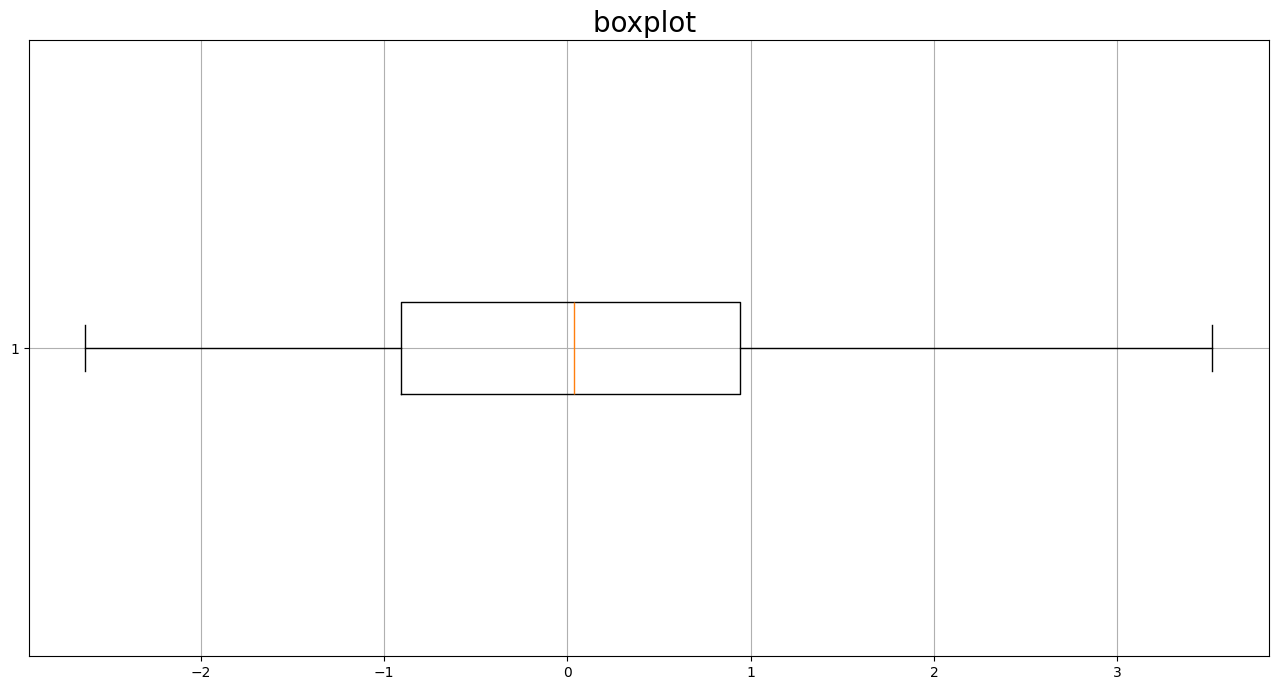

In [370]:
plt.figure(figsize = (16, 8))
plt.grid()
plt.boxplot(e, vert = False)
plt.title('boxplot ', fontsize=20)
plt.show()

In [371]:
if np.size(e_clear)==np.size(e):
    e_clear = e[np.where((e_min < e) & (e_max > e))]
    Y_clear = Y[np.where((e_min < e) & (e_max > e))]
np.size(e_clear)

48

In [372]:
RSS_clear = e_clear.T @ e_clear
TSS_clear = np.sum(((Y_clear - Y_clear.mean()).ravel()) ** 2)
R_clear_square = (TSS_clear - RSS_clear) / TSS_clear
print(f'R^2 = {np.round(R_clear_square, 4)} - коэффициент детерминации после отбрасывания выбросов')

R^2 = 0.8246 - коэффициент детерминации после отбрасывания выбросов


h) Провести кросспроверку регрессии

In [373]:
def cross_validation(sample):
    n = np.size(sample, axis=0)
    CVSS = 0
    for i in range(n):
        train_i = np.vstack((sample[:i, :], sample[(i+1):, :]))
        test_i = sample[i, :]

        PSI, Y = sample[:, :-1], sample[:, -1]
        F_i = PSI.T @ PSI
        F_i_inv = np.linalg.inv(F_i)
        beta_wave = (F_i_inv @ PSI.T @ Y)
        
        x_i = test_i[:-1]
        y_i = test_i[-1]
        
        y_est_i = np.dot(beta_wave, x_i)
        CVSS_i = (y_i - y_est_i) ** 2
        CVSS += CVSS_i
    return CVSS

CVSS = cross_validation(sample)
print(f'CVSS = {np.round(CVSS, 4)} | TSS = {np.round(TSS, 4)} -->' +\
      f' R^2 = {np.round((TSS-CVSS)/TSS, 4)} < 0.7 --> Предсказывает плохо!')

CVSS = 234.0771 | TSS = 466.6756 --> R^2 = 0.4984 < 0.7 --> Предсказывает плохо!


i) Проверить адекватность регрессии, сделав 5 повторных измерений в одной точке

In [374]:
k=5
p = 5 # количество случайных величин кси
n = 50  # объем выборки
a, b = -1, 1

# отклик - это случайная величина распределенная нормально с параметрами mean, sd
mean = lambda X, coefs: np.dot(X, np.array(coefs)) + 2 # etta ~ N(2 + 3x_1 - 2x_2 + x_3 + x_4 - x_5, 1.5**2)
sd = 1.5
factors_a = [uniform(a, b-a) for _ in range(p)]
# реализация вектора факторов
x_a = np.array([stat.rvs(size=1) for stat in factors]).T  # Т, чтобы каждая строка представляла один случайный вектор
X_a = np.tile(x_a, (k, 1)) # повторяем строку 5 раз
# отклик
reaction_a = norm(mean(X_a, [3, -2, 1, 1, -1]), sd)
# реализация отклика
Y_a = reaction_a.rvs(size=k)
Y_a = Y_a.reshape(1, -1).T
sample_a = np.hstack((X_a, Y_a))


In [375]:
df = pd.DataFrame(data=sample_a, columns=names)
sd_est = np.sum((Y_a-np.mean(Y_a))**2) / (k-1)

delta_wave = RSS / ((n-p)*sd_est)
p_value = f(n-p, k-1).sf(delta_wave)

In [376]:
print(f'p-value(delta > {np.round(delta_wave, 4)} | H_0) = {np.round(p_value[0,0], 4)} >' +\
      f' alpha = {0.05} --> Нет оснований отвергать гипотезу --> модель адекватна')
df

p-value(delta > [[0.9664]] | H_0) = 0.6002 > alpha = 0.05 --> Нет оснований отвергать гипотезу --> модель адекватна


,$\xi_1$,$\xi_2$,$\xi_3$,$\xi_4$,$\xi_5$,$\eta$
0,0.060422,0.575646,-0.301639,-0.462137,0.728283,1.020969
1,0.060422,0.575646,-0.301639,-0.462137,0.728283,0.916386
2,0.060422,0.575646,-0.301639,-0.462137,0.728283,-1.772245
3,0.060422,0.575646,-0.301639,-0.462137,0.728283,1.644639
4,0.060422,0.575646,-0.301639,-0.462137,0.728283,-1.271596


j) Удалить переменную соответствующую наименее значимому коэффициенту и повторить пункты b и c, сравнить уравнения регрессии

In [377]:
least_significant_factor_index = np.where(p_values == np.max(p_values))[0][0]
print(f'Наименее значимый фактор - это xi_{least_significant_factor_index}')

X_new = np.hstack((X[:, :least_significant_factor_index-1], X[:, least_significant_factor_index:]))
Y_new = Y
sample_new = np.hstack((X_new, Y_new))
names_new = names[:least_significant_factor_index-1] + names[least_significant_factor_index:]

df = pd.DataFrame(data=sample_new, columns=names_new)
df.head()

Наименее значимый фактор - это xi_5


,$\xi_1$,$\xi_2$,$\xi_3$,$\xi_4$,$\eta$
0,0.324426,0.247679,0.596298,0.627871,3.832853
1,-0.980013,0.183822,0.205116,0.649288,-0.097368
2,-0.898224,-0.030263,-0.050250,0.453196,-0.267356
3,-0.999474,0.688524,-0.146266,0.284340,-1.839102
4,-0.640467,0.433535,0.377307,0.658133,-1.572713


In [378]:
#Повторяем b
# beta~ = F^(-1)*PSI*Y
PSI_new = np.hstack((np.ones((n, 1)), X_new))
F_new = PSI_new.T @ PSI_new
F_inv_new = np.linalg.inv(F_new)
beta_wave_new = (F_inv_new @ PSI_new.T @ Y_new)
beta_wave_new

array([[ 1.90571378],
       [ 2.98066314],
       [-2.12672738],
       [ 1.20810769],
       [ 1.36003632]])

In [379]:
print('eta = ' + str(np.round(beta_wave_new[0], 4)) + ' + ' +\
      ' + '.join([f"{np.round(beta_wave_new[i+1], 4)}*" +\
                  f"xi_{i+1 if i != least_significant_factor_index-1 else i+2}" for i in range(p-1)]))

eta = [1.9057] + [2.9807]*xi_1 + [-2.1267]*xi_2 + [1.2081]*xi_3 + [1.36]*xi_4


In [380]:
e_new = Y_new - PSI_new@beta_wave_new
RSS_new = e_new.T @ e_new
deltas_new = []
p_values_new = []
for i in range(len(beta_wave_new)):
    delta_wave_new = abs((beta_wave_new[i]*(n-p)**0.5) / (F_inv_new[i, i] * RSS_new)**0.5)
    p_value_new = 2 * t(n-p).sf(delta_wave_new) #p-value = 2 * P(delta >= |delta_wave|)
    p_values_new.append(p_value_new)
    deltas_new.append((delta_wave_new, p_value_new)) 
    
for i_new, delta_new in enumerate(deltas_new):
    delta_wave_new, p_value_new = delta_new
    print(f'beta_{i_new}: p-value(delta > {np.round(delta_wave_new, 4)} | H_0) = {np.round(p_value_new, 15)} ' +\
          f'{">" if p_value_new > 0.05 else "<"} alpha = {0.05} --> Коэффициент beta_{i_new} -' +\
          f' {"не значим!" if p_value_new > 0.05 else "значим!"}')

beta_0: p-value(delta > [[7.2517]] | H_0) = [[4.32094e-09]] < alpha = 0.05 --> Коэффициент beta_0 - значим!
beta_1: p-value(delta > [[9.0735]] | H_0) = [[9.982e-12]] < alpha = 0.05 --> Коэффициент beta_1 - значим!
beta_2: p-value(delta > [[4.9102]] | H_0) = [[1.23997393e-05]] < alpha = 0.05 --> Коэффициент beta_2 - значим!
beta_3: p-value(delta > [[2.8031]] | H_0) = [[0.00744082]] < alpha = 0.05 --> Коэффициент beta_3 - значим!
beta_4: p-value(delta > [[2.91]] | H_0) = [[0.00560099]] < alpha = 0.05 --> Коэффициент beta_4 - значим!


In [381]:


#Повторяем с

In [382]:
TSS_new = np.sum(((Y_new - Y_new.mean()).ravel()) ** 2)
R_square_new = (TSS_new - RSS_new) / TSS_new
print(f'R^2_new = {np.round(R_square_new, 4)} - коэффициент детерминации')

R^2_new = [[0.7674]] - коэффициент детерминации


In [383]:


#Cравнение уравнений регрессии

In [384]:
print('1 уравнение')
print('eta = ' + str(np.round(beta_wave[0], 4)) + ' + ' +\
      ' + '.join([f"{np.round(beta_wave[i+1], 4)}*xi_{i+1}" for i in range(p)]))
print()
print('2 уравнение')
print('eta = ' + str(np.round(beta_wave_new[0], 4)) + ' + ' +\
      ' + '.join([f"{np.round(beta_wave_new[i+1], 4)}*" +\
                  f"xi_{i+1 if i != least_significant_factor_index-1 else i+2}" for i in range(p-1)]))

1 уравнение
eta = [1.972] + [3.0409]*xi_1 + [-2.0876]*xi_2 + [1.1298]*xi_3 + [1.2076]*xi_4 + [-0.5964]*xi_5

2 уравнение
eta = [1.9057] + [2.9807]*xi_1 + [-2.1267]*xi_2 + [1.2081]*xi_3 + [1.36]*xi_4


In [385]:
#сравнение короткой регрессии с длинной
delta_wave_comp = abs((RSS_new - RSS)*(n-p)/((RSS)))
p_value_comp = f(1, n-p).sf(delta_wave_comp)

if(p_value_comp > 0.05):
    print(f'p-value(delta > {np.round(delta_wave_comp, 4)} | H_0) = {np.round(p_value_comp, 4)}' +\
      f' > alpha = {0.05} --> Можно откинуть лишний фактор (нет оснований отвергать короткую)')
else:
    print(f'p-value(delta > {np.round(delta_wave_comp, 4)} | H_0) = {np.round(p_value_comp, 4)}' +\
      f' < alpha = {0.05} --> Наименее значимый фактор важен (отвергаем короткую)')

p-value(delta > [[3.3741]] | H_0) = [[0.0728]] > alpha = 0.05 --> Можно откинуть лишний фактор (нет оснований отвергать короткую)


k) Сравнить регрессии бутстрапом (ПОДАРОК)

In [407]:
def bootstrap_comparing_noparanetric(sample, BOOTSTRAP_RANGE=1000):
    delta_ests = []
    k = 0
    for i in (range(BOOTSTRAP_RANGE)):
        indexes = np.random.choice(sample.shape[0], size=sample.shape[0], replace=True)
        sample_i = sample[indexes]
        X_long_i = sample_i[:, :-1]
        Y_long_i = sample_i[:, -1]
        
        #long
        PSI_long = np.hstack((np.ones((n, 1)), X_long_i))
        F_long = PSI_long.T @ PSI_long
        F_inv_long = np.linalg.inv(F_long)
        beta_wave_long = (F_inv_long @ PSI_long.T @ Y_long_i)
        e_long = Y_long_i - PSI_long@beta_wave_long
        RSS_long = e_long.T @ e_long

        #least_significant_factor_index
        deltas_lsf = []
        p_values_lsf = []
        for i in range(len(beta_wave_long)):
            delta_wave_lsf = abs((beta_wave_long[i]*(n-p)**0.5) / (F_inv_long[i, i] * RSS_long)**0.5)
            p_value_lsf = 2 * t(n-p).sf(delta_wave_lsf) #p-value = 2 * P(delta >= |delta_wave|)
            p_values_lsf.append(p_value_lsf)
            deltas_lsf.append((delta_wave_lsf, p_value_lsf)) 
        least_significant_factor_index_i = np.where(p_values_lsf == np.max(p_values_lsf))[0][0]

        
        #short
        X_short_i = np.hstack((X_long_i[:, :least_significant_factor_index_i-1], X_long_i[:, least_significant_factor_index_i:]))
        
        PSI_short = np.hstack((np.ones((n, 1)), X_short_i))
        F_short = PSI_short.T @ PSI_short
        F_inv_short = np.linalg.inv(F_short)
        beta_wave_short = (F_inv_short @ PSI_short.T @ Y_long_i)
        e_short = Y_long_i - PSI_short@beta_wave_short
        RSS_short = e_short.T @ e_short
        

        delta_est_i = abs((RSS_short - RSS_long)*(n-p)/((RSS_long)))

        if delta_est_i > delta_wave_comp:
            k+=1
            delta_ests.append(delta_est_i)

    p_value = k/BOOTSTRAP_RANGE
    return p_value, delta_ests

In [408]:
p_value, delta_ests = bootstrap_comparing_noparanetric(sample)
p_value

0.267

In [409]:
if(p_value > 0.05):
    print(f'p-value = {np.round(p_value, 4)}' +\
      f' > alpha = {0.05} --> Можно откинуть лишний фактор (нет оснований отвергать короткую)')
else:
    print(f'p-value = {np.round(p_value, 4)}' +\
      f' < alpha = {0.05} --> Наименее значимый фактор важен (отвергаем короткую)')

p-value = 0.267 > alpha = 0.05 --> Можно откинуть лишний фактор (нет оснований отвергать короткую)
